In [9]:
"""
Visualization script for multi-run evaluation results.
Creates various plots to analyze system performance across multiple runs.
"""

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import argparse
from typing import Optional, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_palette("Spectral")
# Set the default font family
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']


def load_results(results_path: Path) -> pd.DataFrame:
    """Load the combined results CSV file."""
    df = pd.read_csv(results_path)
    print(f"Loaded {len(df)} rows from {results_path}")
    print(f"Systems: {df['system_name'].unique()}")
    print(f"Runs per system: {df.groupby('system_name')['run'].nunique().to_dict()}")
    print(f"Queries: {df['query_name'].unique()}\n")
    return df


def generate_summary_table(df: pd.DataFrame, save_path: Optional[Path] = None):
    """Generate and save a summary statistics table."""
    summary = df.groupby('system_name').agg({
        'quality': ['mean', 'std', 'min', 'max'],
        'latency': ['mean', 'std', 'min', 'max']
    }).round(3)

    # Add count of runs and queries
    counts = df.groupby('system_name').agg({
        'run': 'nunique',
        'query_name': 'nunique'
    })
    counts.columns = ['n_runs', 'n_queries']

    # Combine into final summary
    final_summary = pd.concat([summary, counts], axis=1)

    print("\n" + "="*80)
    print("SUMMARY STATISTICS TABLE")
    print("="*80)
    print(final_summary.to_string())

    if save_path:
        final_summary.to_csv(save_path / 'summary_statistics.csv')
        print(f"\nSummary saved to {save_path / 'summary_statistics.csv'}")

    return final_summary

In [10]:
def plot_performance_scatter(df: pd.DataFrame, subtitle: str, horizontal_line: Optional[float] = None, vertical_line: Optional[float] = None, save_path: Optional[Path] = None):
    """Create scatter plot showing quality vs latency trade-off."""
    fig, ax = plt.subplots(figsize=(10, 4))
    if horizontal_line is not None:
        ax.axhline(y=horizontal_line, color='gray', linestyle='--', linewidth=1.5,
                   alpha=0.7, zorder=2)
    if vertical_line is not None:
        ax.axvline(x=horizontal_line, color='gray', linestyle='--', linewidth=1.5,
                   alpha=0.7, zorder=2)

    # Create scatter plot with different colors for each system
    systems = df['system_name'].unique()
    colors = sns.color_palette("husl", len(systems))

    for system, color in zip(systems, colors):
        system_df = df[df['system_name'] == system]

        # Plot individual points
        scatter = ax.scatter(system_df['latency'], system_df['quality'],
                           label=system, alpha=0.6, s=50, color=color,
                           edgecolor='black', linewidth=0.5)

        # Add query labels for each point
        for idx, row in system_df.iterrows():
            # Extract just the query number (e.g., 'Q1' from 'Q1' or '1' from other formats)
            query_label = row['query_name']
            if not query_label.startswith('Q'):
                query_label = f"Q{query_label}"

            # Offset labels slightly to avoid overlap with points
            ax.annotate(query_label,
                       (row['latency'], row['quality']),
                       xytext=(3, 3),  # Offset in pixels
                       textcoords='offset points',
                       fontsize=7,
                       alpha=0.7,
                       color=color)

        # Add mean point with larger marker
        mean_latency = system_df['latency'].mean()
        mean_quality = system_df['quality'].mean()
        ax.scatter(mean_latency, mean_quality,
                  s=200, color=color, marker='D', edgecolor='black', linewidth=2,
                  label=f'{system} (mean)', zorder=5)  # Higher zorder to appear on top

    # Invert x-axis so lower latency (better) is on the right
    ax.invert_xaxis()

    fig.suptitle('Quality vs Latency Trade-off', fontsize=14, fontweight='bold', x=0.41)
    ax.set_title('(Best results in top-right corner)', fontsize=11, style='italic', loc='center')
    ax.set_title(subtitle, fontsize=11, style='italic')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches='tight')
    plt.show()

def plot_token_usage_stacked(df: pd.DataFrame, save_path: Optional[Path] = None):
    """Plot token usage as stacked bars showing prompt vs completion tokens."""

    fig, ax = plt.subplots(figsize=(20, 10))

    # Calculate average tokens per question per system
    token_summary = df.groupby(['query_name', 'system_name']).agg({
        'input_tokens': 'mean',
        'output_tokens': 'mean'
    }).reset_index()

    # Pivot for easier plotting
    prompt_pivot = token_summary.pivot(index='query_name', columns='system_name', values='input_tokens')
    completion_pivot = token_summary.pivot(index='query_name', columns='system_name', values='output_tokens')

    # Create stacked bar chart
    x = np.arange(len(prompt_pivot.index))
    width = 0.15

    colors = sns.color_palette("husl", len(prompt_pivot.columns))

    for i, (system, color) in enumerate(zip(prompt_pivot.columns, colors)):
        # Bottom bars (prompt tokens)
        bars1 = ax.bar(x + i*width, prompt_pivot[system], width,
                      label=f'{system} (prompt)', color=color, alpha=0.6)

        # Top bars (completion tokens)
        bars2 = ax.bar(x + i*width, completion_pivot[system], width,
                      bottom=prompt_pivot[system], label=f'{system} (completion)',
                      color=color, alpha=0.9)

        # Add total labels on top
        for j, (bar1, bar2) in enumerate(zip(bars1, bars2)):
            total = bar1.get_height() + bar2.get_height()
            if total > 0:
                ax.text(bar1.get_x() + bar1.get_width()/2., total,
                       f'{int(total)}', ha='center', va='bottom', fontsize=7)

    ax.set_xlabel('Query', fontsize=12)
    ax.set_ylabel('Average Tokens', fontsize=12)
    ax.set_title('Token Usage by Query and System (Prompt + Completion)',
                fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * (len(prompt_pivot.columns) - 1) / 2)
    ax.set_xticklabels(prompt_pivot.index)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path / 'token_usage_stacked.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_generation_calls(df: pd.DataFrame, save_path: Optional[Path] = None):
    """Plot average number of generation calls used by each system for each question."""

    # Check if column exists
    if 'num_generation_calls' not in df.columns:
        print("Warning: num_generation_calls column not found in dataframe. Skipping generation calls plot.")
        return

    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Calculate average generation calls per question per system
    calls_summary = df.groupby(['query_name', 'system_name']).agg({
        'num_generation_calls': ['mean', 'std', 'min', 'max']
    }).reset_index()
    calls_summary.columns = ['query_name', 'system_name', 'mean_calls', 'std_calls', 'min_calls', 'max_calls']

    # Get unique queries and systems
    queries = sorted(df['query_name'].unique())
    systems = df['system_name'].unique()
    colors = sns.color_palette("husl", len(systems))

    # Set up x-axis positions
    x = np.arange(len(queries))
    width = 0.8 / len(systems)

    # Plot 1: Bar chart with error bars
    ax1 = axes[0]
    for i, (system, color) in enumerate(zip(systems, colors)):
        system_data = calls_summary[calls_summary['system_name'] == system]
        # Ensure data is in correct order matching queries
        means = []
        stds = []
        for query in queries:
            query_data = system_data[system_data['query_name'] == query]
            if not query_data.empty:
                means.append(query_data['mean_calls'].values[0])
                stds.append(query_data['std_calls'].values[0])
            else:
                means.append(0)
                stds.append(0)

        offset = (i - len(systems)/2 + 0.5) * width
        bars = ax1.bar(x + offset, means, width, yerr=stds, label=system, color=color,
                      alpha=0.8, edgecolor='black', linewidth=0.5, capsize=3)

        # Add value labels on bars
        for j, (bar, mean_val) in enumerate(zip(bars, means)):
            if mean_val > 0:
                ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                        f'{mean_val:.1f}', ha='center', va='bottom', fontsize=7)

    ax1.set_xlabel('Query', fontsize=12)
    ax1.set_ylabel('Average Number of Generation Calls', fontsize=12)
    ax1.set_title('Generation Calls by Query and System (with std deviation)', fontsize=13, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(queries)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3, axis='y')

    # Plot 2: Heatmap showing generation calls
    ax2 = axes[1]

    # Pivot data for heatmap
    heatmap_data = calls_summary.pivot(index='query_name', columns='system_name', values='mean_calls')

    # Create heatmap
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd',
                ax=ax2, cbar_kws={'label': 'Avg Generation Calls'})
    ax2.set_title('Generation Calls Heatmap', fontsize=13, fontweight='bold')
    ax2.set_xlabel('System', fontsize=12)
    ax2.set_ylabel('Query', fontsize=12)

    plt.suptitle('LLM Generation Calls Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path / 'generation_calls.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print("\nGeneration Calls Summary:")
    print("="*60)
    overall_summary = df.groupby('system_name')['num_generation_calls'].agg([
        'mean', 'std', 'min', 'max', 'sum'
    ]).round(2)
    print(overall_summary)

    # Print detailed breakdown
    print("\nDetailed Generation Calls per System:")
    print("-"*40)
    for system in systems:
        system_df = df[df['system_name'] == system]
        total_calls = system_df['num_generation_calls'].sum()
        avg_calls = system_df['num_generation_calls'].mean()
        print(f"{system}:")
        print(f"  Total calls across all runs: {int(total_calls)}")
        print(f"  Average calls per query: {avg_calls:.2f}")
        print(f"  Min calls: {system_df['num_generation_calls'].min()}")
        print(f"  Max calls: {system_df['num_generation_calls'].max()}")


def plot_generation_calls_by_query(df: pd.DataFrame, save_path: Optional[Path] = None):
    """Plot average number of generation calls for each query, grouped by system."""

    df['num_generation_calls'] = [int(x) for x in df['num_generation_calls']]

    fig, ax = plt.subplots(figsize=(14, 6))

    # Calculate average generation calls per query per system (averaged across runs)
    calls_summary = df.groupby(['query_name', 'system_name'])['num_generation_calls'].mean().reset_index()

    # Get unique queries and systems
    queries = sorted(df['query_name'].unique())
    systems = df['system_name'].unique()
    colors = sns.color_palette("husl", len(systems))

    # Set up x-axis positions
    x = np.arange(len(queries))
    width = 0.8 / len(systems)

    # Create grouped bar chart
    for i, (system, color) in enumerate(zip(systems, colors)):
        system_data = calls_summary[calls_summary['system_name'] == system]

        # Get values in correct order matching queries
        values = []
        for query in queries:
            query_data = system_data[system_data['query_name'] == query]
            if not query_data.empty:
                values.append(query_data['num_generation_calls'].values[0])
            else:
                values.append(0)

        offset = (i - len(systems)/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, label=system, color=color,
                     alpha=0.8, edgecolor='black', linewidth=0.5)

        # Add value labels on bars
        for bar, val in zip(bars, values):
            if val > 0:
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                       f'{val:.1f}', ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Query', fontsize=12)
    ax.set_ylabel('# Generation Calls', fontsize=12)
    ax.set_title('Generation Calls per Query by System', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(queries)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path / 'generation_calls_by_query.png', dpi=300, bbox_inches='tight')
    plt.show()

In [4]:
import statistics

total_gemini_25_flash_costs = sum([
    0.087, 0.0051, 0.0049, 0.0050, 2.38, 1.81,  0.0040,
    0.00042, 0.0015, 0.0023, 0.0023, 0.0011, 0.00087, 0.0046
])
print(f"{total_gemini_25_flash_costs=}")

gemini_20_flash_costs = sum([
    0.027, 0.0016, 0.0015, 0.0016, 0.63, 0.67, 0.0013,
    0.00021, 0.00097, 0.00012, 0.00012, 0.00054, 0.00052, 0.0023
])
print(f"{gemini_20_flash_costs=}")

gpt_4o_mini_costs = sum([
    0.041, 0.0024, 0.0023, 0.0024, 0.62, 0.48, 0.0022,
    0.00021, 0.00058, 0.0012, 0.0012, 0.00069, 0.00053, 0.0023
])
print(f"{gpt_4o_mini_costs=}")

gpt_5_mini_costs = sum([
    0.11, 0.0065, 0.0064, 0.0064, 1.81, 0.0060,
    0.00073, 0.0021, 0.0042, 0.0042, 0.0012, 0.00095, 0.0083
])
print(f"{gpt_5_mini_costs=}")

print(f"Total thalamusdb + lotus costs: {total_gemini_25_flash_costs + gemini_20_flash_costs + gpt_4o_mini_costs + gpt_5_mini_costs}")

total_gemini_25_flash_costs=4.30909
gemini_20_flash_costs=1.33778
gpt_4o_mini_costs=1.1570099999999999
gpt_5_mini_costs=1.96698
Total thalamusdb + lotus costs: 8.770859999999999


Loaded 75 rows from results/latest/unsloth_gemma-3-4b-it-GGUF/all_results_with_runs.csv
Systems: ['blendsql' 'lotus' 'thalamusdb']
Runs per system: {'blendsql': 3, 'lotus': 3, 'thalamusdb': 3}
Queries: ['Q1' 'Q10' 'Q2' 'Q3' 'Q4' 'Q5' 'Q6' 'Q8' 'Q9']



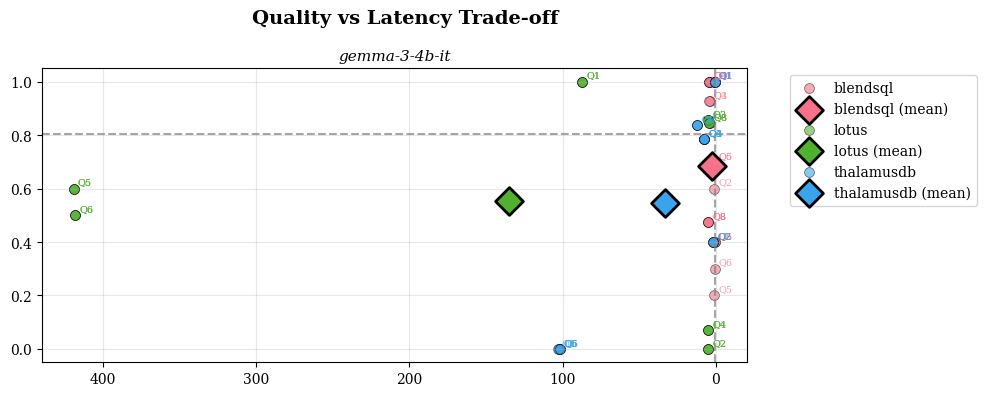

Loaded 75 rows from results/latest/unsloth_gemma-3-12b-it-GGUF/all_results_with_runs.csv
Systems: ['blendsql' 'lotus' 'thalamusdb']
Runs per system: {'blendsql': 3, 'lotus': 3, 'thalamusdb': 3}
Queries: ['Q1' 'Q10' 'Q2' 'Q3' 'Q4' 'Q5' 'Q6' 'Q8' 'Q9']



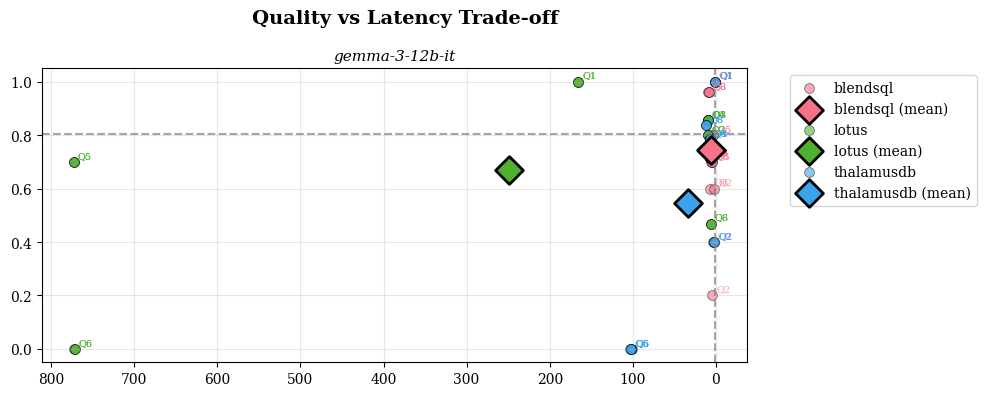

In [11]:
# Quality scores on movies, using Gemini 2.5 Flash and ignoring Q7, Q9, Q10
horizontal_line = statistics.mean([1.0, 1.0, 0.64, 0.64, 0.59, 0.67, 0.93, 1.0, 1.0, 0.64, 0.74, 0.39, 0.83, 0.86, 0.95, 0.92, 0.74, 0.74, 1.0, 0.84, 0.83, 1.0, 1.0, 0.64, 0.64, 0.89, 0.69, 0.76])
vertical_line = statistics.mean([33.1, 2.1, 2.1, 2.8, 536.5, 432.4,  2.3, 3.8, 29.7, 4.6, 4.4, 1.9, 2.3, 4.3, 4.2, 1.9, 3.1, 3.8, 2.3, 1.7, 6.8, 26.3, 9.5, 11.0, 11.4, 54.5, 54.5, 10.9])

model_path_to_tag = {
    "unsloth_gemma-3-4b-it-GGUF": "gemma-3-4b-it",
    "unsloth_gemma-3-12b-it-GGUF": "gemma-3-12b-it",
}

for model_path, model_tag in model_path_to_tag.items():
    results_path = Path(f"results/latest/{model_path}/all_results_with_runs.csv")
    output_dir = results_path.parent / "visualizations"
    if not output_dir.is_dir():
        output_dir.mkdir()
    # Load data
    df = load_results(results_path)
    common_queries = df.groupby('query_name')['system_name'].nunique()[lambda x: x == df['system_name'].nunique()].index.tolist()
    df = df[df['query_name'].isin(common_queries)]
    plot_performance_scatter(
        df,
        subtitle=model_tag,
        horizontal_line=horizontal_line,
        vertical_line=vertical_line,
        save_path=output_dir / "performance_latency_scatter.pdf"
    )

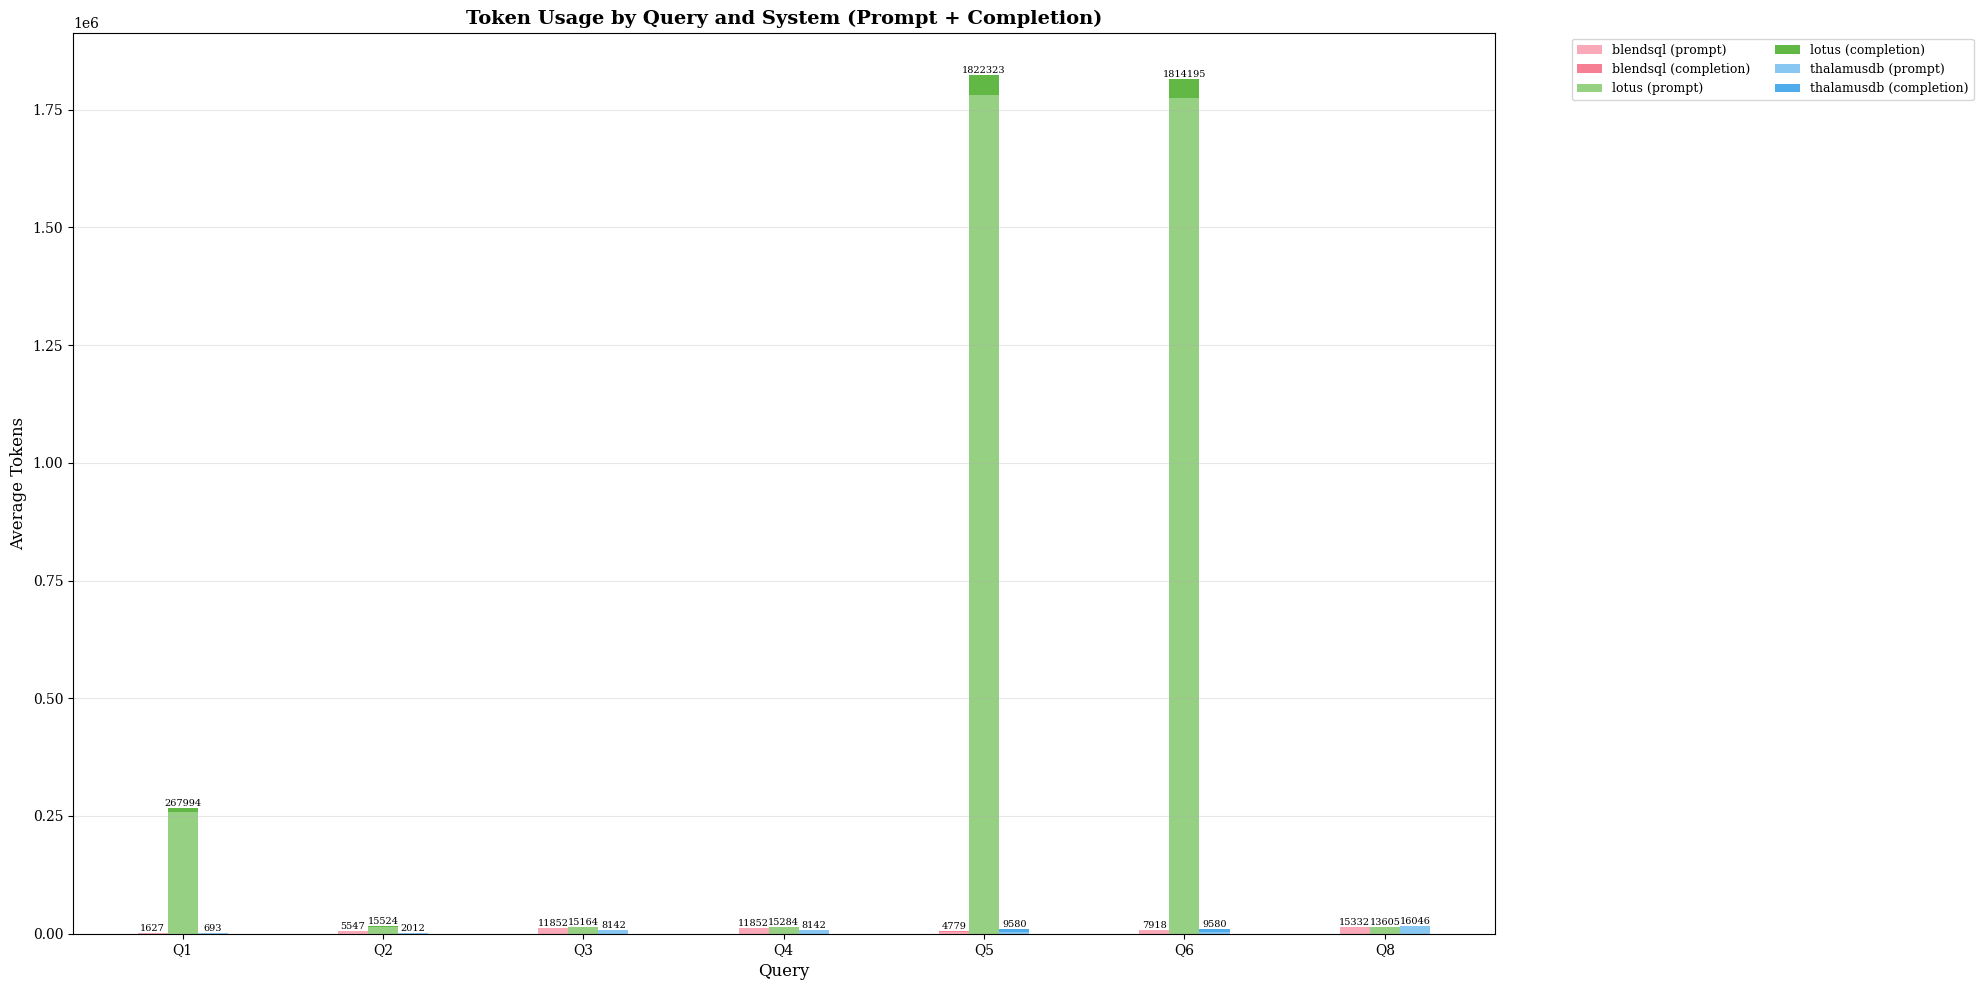

In [12]:
plot_token_usage_stacked(df)

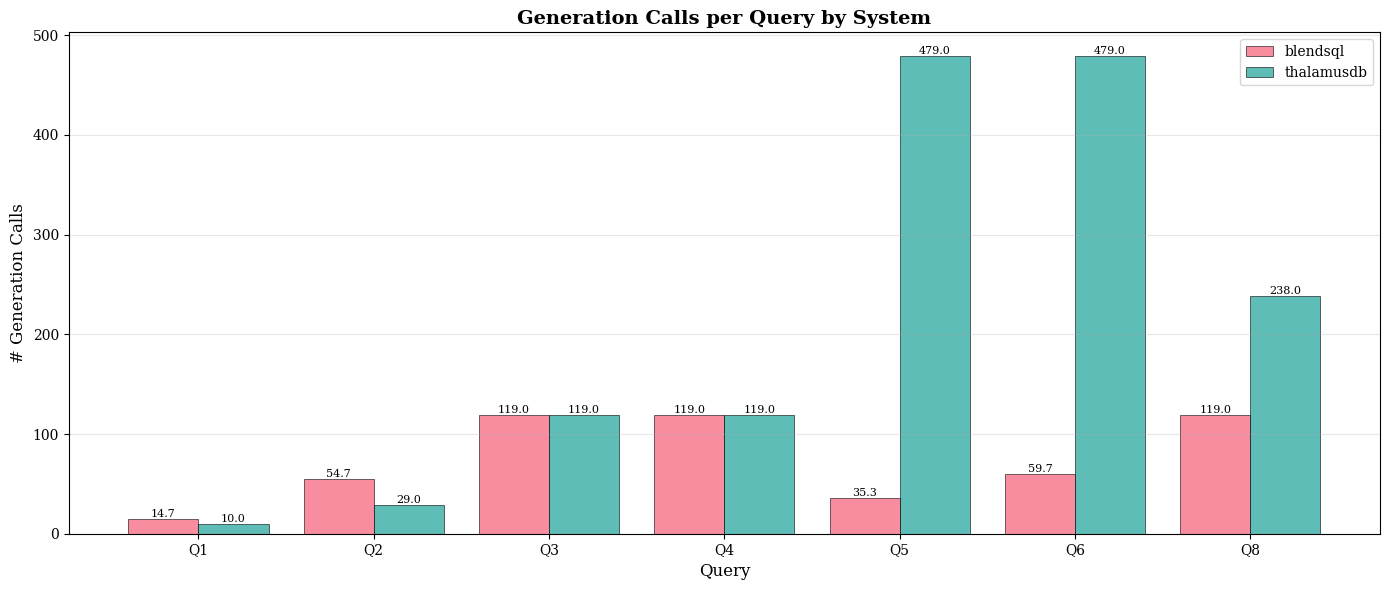

In [13]:
plot_generation_calls_by_query(df[df['system_name'].isin(['thalamusdb', 'blendsql'])])

In [15]:
df[(df['system_name'] == 'blendsql') & (df['query_name'] == 'Q1')]

,Unnamed: 0,system_name,query_name,latency,prediction,num_generation_calls,output_tokens,input_tokens,run,metrics,raw_metrics,quality
0,0,blendsql,Q1,1.002904,"{""columns"":[""reviewId""],""data"":[[2610735],[269...",12,24,1342,1,NaN,"{'precision': 1.0, 'recall': 1.0, 'f1_score': ...",1.0
9,9,blendsql,Q1,1.577655,"{""columns"":[""reviewId""],""data"":[[2325604],[258...",20,40,2110,2,NaN,"{'precision': 1.0, 'recall': 1.0, 'f1_score': ...",1.0
18,18,blendsql,Q1,1.050093,"{""columns"":[""reviewId""],""data"":[[2610735],[269...",12,24,1342,3,NaN,"{'precision': 1.0, 'recall': 1.0, 'f1_score': ...",1.0


In [16]:
df[(df['system_name'] == 'thalamusdb') & (df['query_name'] == 'Q1')]

,Unnamed: 0,system_name,query_name,latency,prediction,num_generation_calls,output_tokens,input_tokens,run,metrics,raw_metrics,quality
54,54,thalamusdb,Q1,0.815646,"{""columns"":[""reviewid""],""data"":[[2602222],[267...",10,20,673,1,NaN,"{'precision': 1.0, 'recall': 1.0, 'f1_score': ...",1.0
61,61,thalamusdb,Q1,0.900856,"{""columns"":[""reviewid""],""data"":[[2602222],[267...",10,20,673,2,NaN,"{'precision': 1.0, 'recall': 1.0, 'f1_score': ...",1.0
68,68,thalamusdb,Q1,0.817568,"{""columns"":[""reviewid""],""data"":[[2602222],[267...",10,20,673,3,NaN,"{'precision': 1.0, 'recall': 1.0, 'f1_score': ...",1.0
